In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dharmikyash7118
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 198MB/s] 


In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device="cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [ ]:
image_path=[]
labels=[]
for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      labels.append(label)
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")

data_df=pd.DataFrame(zip(image_path,labels),columns=['image_path','labels'])
data_df.head()

,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [ ]:
train=data_df.sample(frac=0.7,random_state=7)
test=data_df.drop(train.index)

val=test.sample(frac=0.5,random_state=7)
test=test.drop(val.index)

In [ ]:
label_encoder=LabelEncoder()
label_encoder.fit(train["labels"])
transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform=None):
    self.dataframe=dataframe
    self.transform=transform
    self.labels=torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, index):
    image_path=self.dataframe.iloc[index,0]
    label=self.labels[index]
    image=Image.open(image_path).convert('RGB')
    if self.transform:
      image=self.transform(image).to(device)
    return image,label

In [ ]:
train_dataset=CustomImageDataset(dataframe=train,transform=transform)
val_dataset=CustomImageDataset(dataframe=val,transform=transform)
test_dataset=CustomImageDataset(dataframe=test,transform=transform)

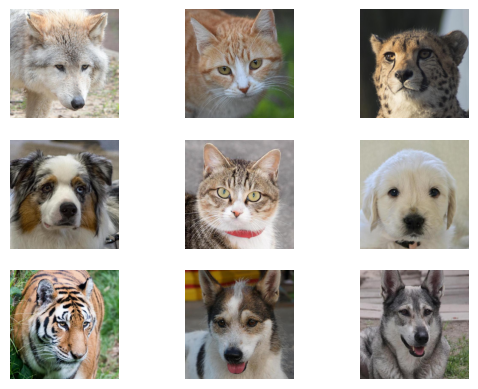

In [ ]:
nrows,ncols=3,3
f,axarr=plt.subplots(nrows,ncols)
for row in range(nrows):
  for col in range(ncols):
    image = Image.open(data_df.sample(n = 1)['image_path'].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')
plt.show()

In [ ]:
LR=0.001
BATCH_SIZE=16
EPOCHS=10

In [ ]:
train_dataloader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.pooling=nn.MaxPool2d(2,2)
    self.relu=nn.ReLU()
    self.flatten=nn.Flatten()
    self.linear=nn.Linear((128*16*16),128)
    self.output=nn.Linear(128,len(data_df['labels'].unique()))

  def forward(self,x):
    x=self.conv1(x)
    x=self.pooling(x)
    x=self.relu(x)
    x=self.conv2(x)
    x=self.pooling(x)
    x=self.relu(x)
    x=self.conv3(x)
    x=self.pooling(x)
    x=self.relu(x)
    x=self.flatten(x)
    x=self.linear(x)
    x=self.output(x)

    return x

model=Net().to(device)

In [ ]:
from torchsummary import summary
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=LR)

In [ ]:
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

for epoch in range(EPOCHS):
  total_acc_train=0
  total_loss_train=0
  total_acc_val=0
  total_loss_val=0

  for inputs,labels in train_dataloader:
    optimizer.zero_grad()
    outputs=model(inputs)
    train_loss=criterion(outputs,labels)
    total_loss_train+=train_loss.item()
    train_loss.backward()

    train_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
    total_acc_train+=train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs,labels in val_dataloader:
      outputs=model(inputs)
      val_loss=criterion(outputs,labels)
      total_loss_val+=val_loss.item()

      val_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
      total_acc_val+=val_acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100,4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100,4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("-"*50)

Epoch 1/10, Train Loss: 0.1667 Train Accuracy 99.2649
              Validation Loss: 0.2926 Validation Accuracy: 95.6198
--------------------------------------------------
Epoch 2/10, Train Loss: 0.2718 Train Accuracy 98.6449
              Validation Loss: 0.2369 Validation Accuracy: 96.1983
--------------------------------------------------
Epoch 3/10, Train Loss: 0.1375 Train Accuracy 99.2915
              Validation Loss: 0.268 Validation Accuracy: 96.405
--------------------------------------------------
Epoch 4/10, Train Loss: 0.2112 Train Accuracy 98.9372
              Validation Loss: 0.3484 Validation Accuracy: 95.0413
--------------------------------------------------
Epoch 5/10, Train Loss: 0.0999 Train Accuracy 99.5572
              Validation Loss: 0.2968 Validation Accuracy: 96.7769
--------------------------------------------------
Epoch 6/10, Train Loss: 0.1108 Train Accuracy 99.4686
              Validation Loss: 0.3901 Validation Accuracy: 95.5372
---------------------

In [ ]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0
  for inputs,labels in test_dataloader:
    predictions=model(inputs)

    acc=(torch.argmax(predictions,axis=1)==labels).sum().item()
    total_acc_test+=acc
    test_loss=criterion(predictions,labels)
    total_loss_test+=test_loss.item()
print(f"Accuracy Score is:{round((total_acc_test/test_dataset.__len__())*100,4)} and Loss is {round(total_loss_test/1000,4)}")


Accuracy Score is:95.8661 and Loss is 0.034


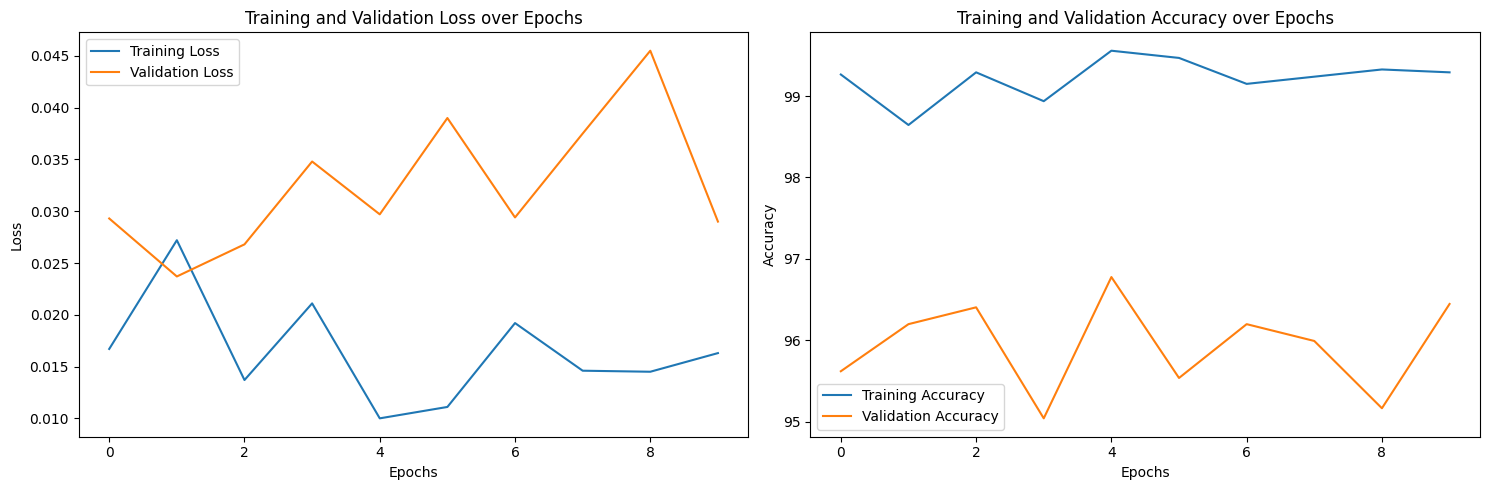

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axs[0].plot(total_loss_train_plot,label="Training Loss")
axs[0].plot(total_loss_validation_plot,label='Validation Loss')
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot,label='Training Accuracy')
axs[1].plot(total_acc_validation_plot,label='Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

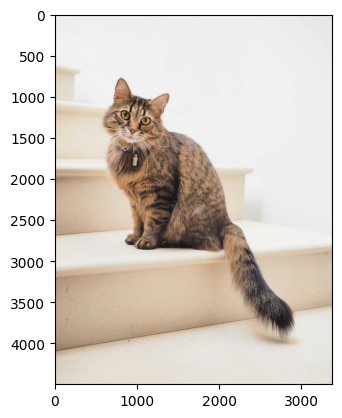


Prediction: 



array(['dog'], dtype=object)

In [ ]:
def predict_image(image_path):
  image=Image.open(image_path).convert('RGB')
  image=transform(image).to(device)

  output=model(image.unsqueeze(0))
  output=torch.argmax(output,axis=1).item()
  return label_encoder.inverse_transform([output])

image=Image.open("/content/catimg.jpg")
plt.imshow(image)
plt.show()

print()
print("Prediction: \n")
predict_image("/content/catimg.jpg")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')